In [264]:
# importing packages

import pandas as pd
from ast import literal_eval
import numpy as np
import time
from geopy import distance

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


from sklearn import  cluster
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import scipy
import seaborn as sns; sns.set()

In [265]:
#graph formatting

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 7)

In [266]:
# Read the GTD CSV file
terrorism_df = pd.read_csv('globalterrorismdata.csv')

C:\Users\aryan\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (4,31,33,54,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [267]:
# select the south amrican region
south_america = terrorism_df['region'] == 3
south_america_df = terrorism_df

# create a data frame with only the south american region
south_america_df = terrorism_df[south_america]
south_america_df1 = terrorism_df[south_america]

In [268]:
# select the data columns names from the GTD
data_columns =  ["eventid", "iyear", "imonth", "iday", "country_txt", "city", "gname", 
                 "attacktype1_txt", "weaptype1_txt", "targsubtype1_txt", "nkill", "latitude", "longitude"]

# create a new dataframe with the selected columns
SA_terror_df = south_america_df[data_columns]

# updating the names of each column
SA_terror_df.columns = ["event_id", "year", "month", "day", "country",
                        "city", "group_name", "attack_type",
                        "weapon_type", "target_type", "number_killed", 
                        "latitude", "longitude"] 



In [269]:
# print the number of events in each country
print(SA_terror_df['country'].value_counts())

Colombia            8742
Peru                6109
Chile               2444
Argentina            821
Bolivia              317
Venezuela            313
Brazil               287
Ecuador              238
Paraguay             118
Uruguay               82
Suriname              66
Guyana                27
French Guiana          7
Falkland Islands       1
Name: country, dtype: int64


In [270]:
# remove the countries French Guiana and Falkland Islands

french_guiana_falkland_islands = SA_terror_df[(SA_terror_df['country'] == 'French Guiana') | (SA_terror_df['country'] == 'Falkland Islands')].index
SA_terror_df.drop(french_guiana_falkland_islands,  inplace = True)

C:\Users\aryan\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [271]:
# drop the na values

SA_terror_df.dropna(inplace=True)

<ipython-input-271-fbb18ba3531d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SA_terror_df.dropna(inplace=True)


In [272]:
# create a city_country column by concatinating each city and its respective country
SA_terror_df['city_country'] = SA_terror_df['city'] + ', ' + SA_terror_df['country']

# create a location id for each city
SA_terror_df['location_id'] = SA_terror_df.groupby(['city_country']).ngroup()


<ipython-input-272-7cb553914381>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SA_terror_df['city_country'] = SA_terror_df['city'] + ', ' + SA_terror_df['country']
<ipython-input-272-7cb553914381>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SA_terror_df['location_id'] = SA_terror_df.groupby(['city_country']).ngroup()


In [273]:
# create a coordinates column that concatinates the latitude and longitude columns

# format the coordinates coulmn to be comma separated
SA_terror_df['coordinates'] = SA_terror_df['latitude'].map(str) + ', ' + SA_terror_df['longitude'].map(str)
# apply to each row of the dataframe
SA_terror_df['coordinates'] = SA_terror_df.coordinates.apply(lambda x: literal_eval(str(x)))

<ipython-input-273-35c98dd877d4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SA_terror_df['coordinates'] = SA_terror_df['latitude'].map(str) + ', ' + SA_terror_df['longitude'].map(str)
<ipython-input-273-35c98dd877d4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SA_terror_df['coordinates'] = SA_terror_df.coordinates.apply(lambda x: literal_eval(str(x)))


In [274]:
# create a date column that concatinatates the year, day and month columns

# set day 0 to 1
SA_terror_df.loc[SA_terror_df['day'] == 0, 'day'] = 1

# create a date column and format it in mm/dd/yyy 
SA_terror_df['date'] = SA_terror_df['month'].map(str) + '/' + SA_terror_df['day'].map(str) + '/' + SA_terror_df['year'].map(str)

# set the date column data type as datetime
SA_terror_df['date']= pd.to_datetime(SA_terror_df['date'])

# change the year data type to string
SA_terror_df['year'] = SA_terror_df['year'].astype(str)

# drop the previous extra calendar columns
SA_terror_df.drop(columns = ['year', 'month', 'day'], inplace = True)

C:\Users\aryan\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
<ipython-input-274-bd53af9482fa>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SA_terror_df['date'] = SA_terror_df['month'].map(str) + '/' + SA_terror_df['day'].map(str) + '/' + SA_terror_df['year'].map(str)
<ipython-input-274-bd53af9482fa>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [275]:
# read earthquke csv and save it as earthquake_df
earthquake_df = pd.read_csv('earthquake.csv')

In [276]:
# create the year, month and day column from the time column

# create 3 columns for year, month and day from the time column
earthquake_df[['year', 'month', 'day']] = earthquake_df['time'].str.split('-', expand=True)

#format the new day column to remoce the T
earthquake_df['day'] = earthquake_df['day'].str.split('T', expand=True)

# create a date column and format it in mm/dd/yyy 
earthquake_df['date'] = earthquake_df['month'].map(str) + '/' + earthquake_df['day'].map(str) + '/' + earthquake_df['year'].map(str)

# create a date column from the year, month and day columns and set the data type to datetime
earthquake_df['date']= pd.to_datetime(earthquake_df['date'])

# drop the previous extra calendar columns
earthquake_df.drop(columns = ['year', 'month', 'day'], inplace = True)

In [277]:
# create an id column
earthquake_df['id'] = earthquake_df.index + 1

In [278]:
# create a coordinates column by concatinating each latitude and longitude of the earthquake
earthquake_df['coordinates'] = earthquake_df['latitude'].map(str) + ', ' + earthquake_df['longitude'].map(str)

# apply this to each row of the earthquake dataframe
earthquake_df['coordinates'] = earthquake_df.coordinates.apply(lambda x: literal_eval(str(x)))

In [279]:
# selecing the columns that I will use
earthquake_df = earthquake_df[['id', 'date','coordinates', 'latitude', 'longitude', 'mag' ]]

In [280]:
# create conditions that divids the South America into 3 parts

# conditions for the earthquake data frame
conditions_location_earthquake_df = [
                       (earthquake_df['latitude'] < 13) & (earthquake_df['latitude'] > -10) & (earthquake_df['longitude'] > -90) & (earthquake_df['longitude'] < -34),
                       (earthquake_df['latitude'] < -10) & (earthquake_df['latitude'] > -30) & (earthquake_df['longitude'] > -90) & (earthquake_df['longitude'] < -34),
                       (earthquake_df['latitude'] < -30) & (earthquake_df['latitude'] > -60) & (earthquake_df['longitude'] > -90) & (earthquake_df['longitude'] < -34),
                       ]


# conditions for the GTD data frame
conditions_location_SA_terror_df = [                      
                       (SA_terror_df['latitude'] < 13) & (SA_terror_df['latitude'] > -10) & (SA_terror_df['longitude'] > -90) & (SA_terror_df['longitude'] < -34),
                       (SA_terror_df['latitude'] < -10) & (SA_terror_df['latitude'] > -30) & (SA_terror_df['longitude'] > -90) & (SA_terror_df['longitude'] < -34),
                       (SA_terror_df['latitude'] < -30) & (SA_terror_df['latitude'] > -60) & (SA_terror_df['longitude'] > -90) & (SA_terror_df['longitude'] < -34),
                       ]

# names of conditions
values_location = ['upper', 'midle', 'lower']


In [281]:
# apply the contient division conditions to the earthquake data frame
earthquake_df['region'] = np.select(conditions_location_earthquake_df, values_location)

# apply the contient division conditions to the GTD data frame
SA_terror_df['region'] = np.select(conditions_location_SA_terror_df, values_location)

<ipython-input-281-144cfc3c0525>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SA_terror_df['region'] = np.select(conditions_location_SA_terror_df, values_location)


In [282]:
#remove earthquakes that are out of range from the condition
out_of_range_earthquake = earthquake_df[(earthquake_df['region'] == '0')].index
earthquake_df.drop(out_of_range_earthquake,  inplace = True)

In [283]:
# create an elbow plot to determine the number of clusters needed for the earthquake dataframe

X_quake = earthquake_df[["latitude","longitude"]]
max_k = 10

## iterations
distortions = [] 
for i in range(1, max_k+1):
    if len(X_quake) >= i:
       model = cluster.KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
       model.fit(X_quake)
       distortions.append(model.inertia_)
    
## best k: the lowest derivative
k_quake = [i*100 for i in np.diff(distortions,2)].index(min([i*100 for i 
     in np.diff(distortions,2)]))

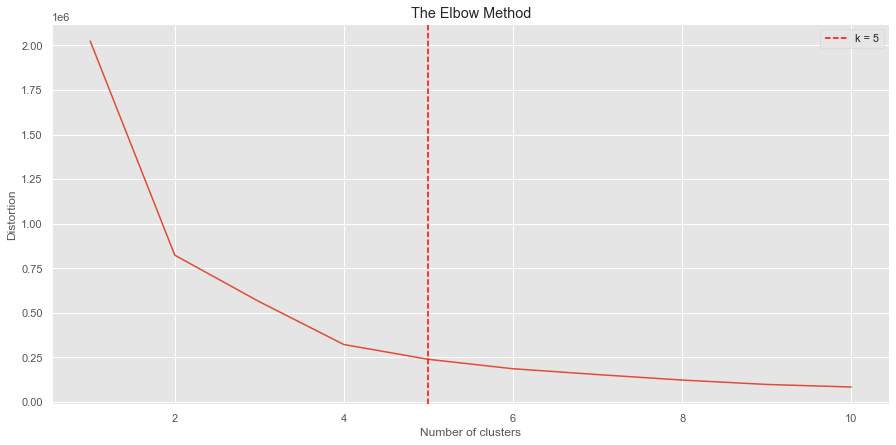

In [284]:
# plot the elbow figure for the earthquake dataframe

fig, ax = plt.subplots()
ax.plot(range(1, len(distortions)+1), distortions)
ax.axvline(k_quake, ls='--', color="red", label="k = "+str(k_quake))
ax.set(title='The Elbow Method', xlabel='Number of clusters', 
       ylabel="Distortion")
ax.legend()
ax.grid(True)
plt.show()


In [285]:
# perform K-means clustering on the latidude and longitude of the earthquake data

model = cluster.KMeans(n_clusters=k_quake, init='k-means++')
X_quake = earthquake_df[["longitude","latitude"]]

# clustering
earthquake_df_X = X_quake.copy()
earthquake_df_X["cluster"] = model.fit_predict(X_quake)

# find centroids
closest, distances = scipy.cluster.vq.vq(model.cluster_centers_, earthquake_df_X.drop("cluster", axis=1).values)
earthquake_df_X["centroids"] = 0

for i in closest:
    earthquake_df_X["centroids"].iloc[i] = 1
    
# add clustering info to the earthquake dataframe
earthquake_df["cluster"] = earthquake_df_X["cluster"]

C:\Users\aryan\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


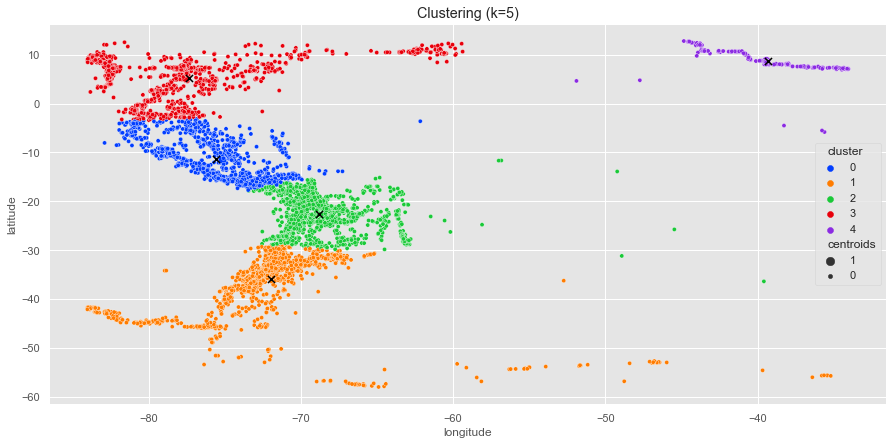

In [286]:
# plot the k-means cluster of the earthquake data

fig, ax = plt.subplots()
sns.scatterplot(x="longitude", y="latitude", data=earthquake_df_X, 
                palette=sns.color_palette("bright",k_quake),
                hue='cluster', size="centroids", size_order=[1,0],
                legend="brief", ax=ax).set_title('Clustering (k='+str(k_quake)+')')

# store the longitude and latitude of the earthquake clusters
th_centroids_quake = model.cluster_centers_

# display the centroids (hotspots) as an "x" on the plot
ax.scatter(th_centroids_quake[:,0], th_centroids_quake[:,1], s=50, c='black', 
           marker="x")

In [287]:
# create a data frame of the centers of the earthquake clusters
earthquake_center_df = pd.DataFrame(data=th_centroids_quake, columns=["longitude", "latitude"])

# re-order the columns so latitude is before longitude
earthquake_center_df = earthquake_center_df[["latitude", "longitude"]]

# convert the centers (hot spots) dataframe to a list
earthquake_center_list = list(earthquake_center_df.itertuples(index = False))


In [288]:
#function to calculate the distance from the centers

def calc_distance(from_loc, to_lat, to_long):
    return distance.distance(from_loc, (to_lat, to_long))

In [289]:

# create 5 colums that show the distance of each terror event to each cluster
SA_terror_df['km_from_center1'] = SA_terror_df.apply(lambda row: calc_distance(earthquake_center_list[0], row.latitude, row.longitude),axis=1).astype(str).str[:-3].astype(float)
SA_terror_df['km_from_center2'] = SA_terror_df.apply(lambda row: calc_distance(earthquake_center_list[1], row.latitude, row.longitude),axis=1).astype(str).str[:-3].astype(float)
SA_terror_df['km_from_center3'] = SA_terror_df.apply(lambda row: calc_distance(earthquake_center_list[2], row.latitude, row.longitude),axis=1).astype(str).str[:-3].astype(float)
SA_terror_df['km_from_center4'] = SA_terror_df.apply(lambda row: calc_distance(earthquake_center_list[3], row.latitude, row.longitude),axis=1).astype(str).str[:-3].astype(float)
SA_terror_df['km_from_center5'] = SA_terror_df.apply(lambda row: calc_distance(earthquake_center_list[4], row.latitude, row.longitude),axis=1).astype(str).str[:-3].astype(float)


<ipython-input-289-b8f3d0829277>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SA_terror_df['km_from_center1'] = SA_terror_df.apply(lambda row: calc_distance(earthquake_center_list[0], row.latitude, row.longitude),axis=1).astype(str).str[:-3].astype(float)
<ipython-input-289-b8f3d0829277>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SA_terror_df['km_from_center2'] = SA_terror_df.apply(lambda row: calc_distance(earthquake_center_list[1], row.latitude, row.longitude),axis=1).astype(str).str[:-3].astype

In [290]:

# conditons to categorize what center is closest to the city of the terror event

nearest_center = [(SA_terror_df['km_from_center1'] < SA_terror_df['km_from_center2'])
                  & (SA_terror_df['km_from_center1'] < SA_terror_df['km_from_center3'])
                  & (SA_terror_df['km_from_center1'] < SA_terror_df['km_from_center4'])
                  & (SA_terror_df['km_from_center1'] < SA_terror_df['km_from_center5']),
                      
                  (SA_terror_df['km_from_center2'] < SA_terror_df['km_from_center1'])
                  & (SA_terror_df['km_from_center2'] < SA_terror_df['km_from_center3'])
                  & (SA_terror_df['km_from_center2'] < SA_terror_df['km_from_center4'])
                  & (SA_terror_df['km_from_center2'] < SA_terror_df['km_from_center5']),
                  
                  (SA_terror_df['km_from_center3'] < SA_terror_df['km_from_center1'])
                  & (SA_terror_df['km_from_center3'] < SA_terror_df['km_from_center2'])
                  & (SA_terror_df['km_from_center3'] < SA_terror_df['km_from_center4'])
                  & (SA_terror_df['km_from_center3'] < SA_terror_df['km_from_center5']),
                      
                  (SA_terror_df['km_from_center4'] < SA_terror_df['km_from_center1'])
                  & (SA_terror_df['km_from_center4'] < SA_terror_df['km_from_center2'])
                  & (SA_terror_df['km_from_center4'] < SA_terror_df['km_from_center3'])
                  & (SA_terror_df['km_from_center4'] < SA_terror_df['km_from_center5']),
                      
                  (SA_terror_df['km_from_center5'] < SA_terror_df['km_from_center1'])
                  & (SA_terror_df['km_from_center5'] < SA_terror_df['km_from_center2'])
                  & (SA_terror_df['km_from_center5'] < SA_terror_df['km_from_center3'])
                  & (SA_terror_df['km_from_center5'] < SA_terror_df['km_from_center4']),
                  ]


center_options = [SA_terror_df['km_from_center1'], SA_terror_df['km_from_center2'], SA_terror_df['km_from_center3'], SA_terror_df['km_from_center4'], SA_terror_df['km_from_center5']]

# create a column for the distance that is the closest
SA_terror_df['nearest_center_km'] = np.select(nearest_center, center_options)


<ipython-input-290-def65aedcfee>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SA_terror_df['nearest_center_km'] = np.select(nearest_center, center_options)


In [291]:
# create a column for the name of the center (hot spot) that is closest to each city
SA_terror_df['nearest_earthquake_centroid'] = 0

for i in range(0,len(SA_terror_df)):
    x = SA_terror_df['nearest_center_km'].iloc[i]
    if x == SA_terror_df['km_from_center1'].iloc[i]:
        SA_terror_df['nearest_earthquake_centroid'].iloc[i] = 1
    elif x == SA_terror_df['km_from_center2'].iloc[i]:
        SA_terror_df['nearest_earthquake_centroid'].iloc[i] = 2
    elif x == SA_terror_df['km_from_center3'].iloc[i]:
        SA_terror_df['nearest_earthquake_centroid'].iloc[i] = 3
    elif x == SA_terror_df['km_from_center4'].iloc[i]:
        SA_terror_df['nearest_earthquake_centroid'].iloc[i] = 4
    elif x == SA_terror_df['km_from_center5'].iloc[i]:
        SA_terror_df['nearest_earthquake_centroid'].iloc[i] = 5

<ipython-input-291-9ac1f97d4920>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SA_terror_df['nearest_earthquake_centroid'] = 0
C:\Users\aryan\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\aryan\anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

In [292]:
# drop the columns to only show the column that has the nearest centroid
SA_terror_df.drop(columns = ['km_from_center1', 'km_from_center2',  'km_from_center3', 'km_from_center4', 'km_from_center5'], inplace = True)

C:\Users\aryan\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [293]:
#remove cities that only occur once in the data frame
SA_terror_df = SA_terror_df[SA_terror_df.groupby('city_country').city_country.transform('count')>1]

In [294]:
# remove rows that have unknown values

SA_terror_df = SA_terror_df.loc[SA_terror_df["attack_type"] != 'Unknown']
SA_terror_df = SA_terror_df.loc[SA_terror_df["target_type"] != 'Unknown']

In [194]:
# define the features for the models
features = SA_terror_df[['attack_type', 'city_country', 'target_type', 'nearest_center_km']]

# convert categorical variables to dummy & apply one-hot-encoding
features = pd.get_dummies(features, columns=['attack_type', 'target_type'], prefix = ['dummy', 'dummy'])

# create train/test split of 03/70
SA_terror_train, SA_terror_test = train_test_split(features, test_size =0.3)

# set train x values to be all the features excluding the target
features_train_x = SA_terror_train.loc[:, features.columns != 'city_country']
# set train y value to be the target
features_train_y = SA_terror_train['city_country']

# set test x values to be all the features excluding the target
features_test_x = SA_terror_test.loc[:, features.columns != 'city_country']
# set test y value to be the target
features_test_y = SA_terror_test['city_country']

In [195]:
# creat a correlation matrix
corr_matrix = features.corr(method = 'pearson')
corr_matrix

,nearest_center_km,dummy_Armed Assault,dummy_Assassination,dummy_Bombing/Explosion,dummy_Facility/Infrastructure Attack,dummy_Hijacking,dummy_Hostage Taking (Barricade Incident),dummy_Hostage Taking (Kidnapping),dummy_Unarmed Assault,dummy_Affiliated Institution,...,dummy_Television Journalist/Staff/Facility,dummy_Terrorist,dummy_Tour Bus/Van,dummy_Tourism Travel Agency,dummy_Tourist,dummy_Train/Train Tracks/Trolley,dummy_Unnamed Civilian/Unspecified,dummy_Vehicles/Transportation,dummy_Village/City/Town/Suburb,dummy_Water Supply
nearest_center_km,1.000000,0.016453,-0.000530,-0.083751,0.036784,0.041628,-0.006559,0.096061,0.052535,0.021890,...,0.034630,0.001069,-0.003863,-0.004663,0.018298,-0.011057,-0.004561,0.012736,-0.031371,-0.026111
dummy_Armed Assault,0.016453,1.000000,-0.216032,-0.513314,-0.108899,-0.030554,-0.058443,-0.128863,-0.026197,-0.007551,...,-0.019542,-0.008826,0.009458,-0.004189,-0.015682,-0.036204,0.021375,0.018758,0.265059,-0.020729
dummy_Assassination,-0.000530,-0.216032,1.000000,-0.446204,-0.094662,-0.026560,-0.050803,-0.112016,-0.022772,-0.012082,...,0.005281,0.056826,-0.008144,-0.003642,0.017162,-0.039891,0.137762,-0.032940,-0.077711,-0.025794
dummy_Bombing/Explosion,-0.083751,-0.513314,-0.446204,1.000000,-0.224926,-0.063109,-0.120712,-0.266161,-0.054109,0.006792,...,-0.015199,-0.043050,0.003211,0.008161,-0.032390,0.075471,-0.123776,-0.024761,-0.128178,0.045899
dummy_Facility/Infrastructure Attack,0.036784,-0.108899,-0.094662,-0.224926,1.000000,-0.013388,-0.025609,-0.056466,-0.011479,0.030380,...,0.005061,-0.010395,-0.004105,-0.001836,-0.006872,-0.016398,-0.032892,0.071922,-0.024617,-0.007293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
dummy_Train/Train Tracks/Trolley,-0.011057,-0.036204,-0.039891,0.075471,-0.016398,0.007027,-0.004103,-0.020603,-0.004837,-0.002567,...,-0.005312,-0.004381,-0.001730,-0.000774,-0.002896,1.000000,-0.016348,-0.007956,-0.017409,-0.005479
dummy_Unnamed Civilian/Unspecified,-0.004561,0.021375,0.137762,-0.123776,-0.032892,0.036134,-0.013727,0.040422,-0.009332,-0.004951,...,-0.010248,-0.008451,-0.003338,-0.001492,-0.005587,-0.016348,1.000000,-0.015349,-0.033585,-0.010571
dummy_Vehicles/Transportation,0.012736,0.018758,-0.032940,-0.024761,0.071922,0.021663,-0.003015,0.004836,-0.004542,-0.002410,...,-0.004987,-0.004113,-0.001624,-0.000726,-0.002719,-0.007956,-0.015349,1.000000,-0.016344,-0.005144
dummy_Village/City/Town/Suburb,-0.031371,0.265059,-0.077711,-0.128178,-0.024617,-0.011591,0.004583,-0.031327,-0.009938,-0.005273,...,-0.010913,-0.009000,-0.003554,-0.001589,-0.005949,-0.017409,-0.033585,-0.016344,1.000000,-0.011257


In [196]:
# creating models for test using the CART algorithm, C5.0 algorithm, and random forest algorithm
cart01 = DecisionTreeClassifier(criterion = "gini", max_leaf_nodes=100).fit(features_train_x,features_train_y)
c50_01 = DecisionTreeClassifier(criterion="entropy",max_leaf_nodes=100).fit(features_train_x,features_train_y)
rf01 = RandomForestClassifier(n_estimators = 10,criterion="gini").fit(features_train_x,features_train_y)

In [197]:
# predicting city for Cart, C50.0, and Random Forrest
prediction_cart01 = cart01.predict(features_train_x)
prediction_c50_01 = c50_01.predict(features_train_x)
prediction_rf01 = rf01.predict(features_train_x)

In [198]:
# creating models for training using the CART algorithm, C5.0 algorithm, and random forest models
cart02 = DecisionTreeClassifier(criterion = "gini", max_leaf_nodes=100).fit(features_test_x,features_test_y)
c50_02 = DecisionTreeClassifier(criterion="entropy",max_leaf_nodes=100).fit(features_test_x,features_test_y)
rf02 = RandomForestClassifier(n_estimators = 10,criterion="gini").fit(features_test_x,features_test_y)

In [199]:
#predicting city for test set
prediction_cart02 = cart02.predict(features_test_x)
prediction_c50_02 = c50_02.predict(features_test_x)
prediction_rf02 = rf02.predict(features_test_x)

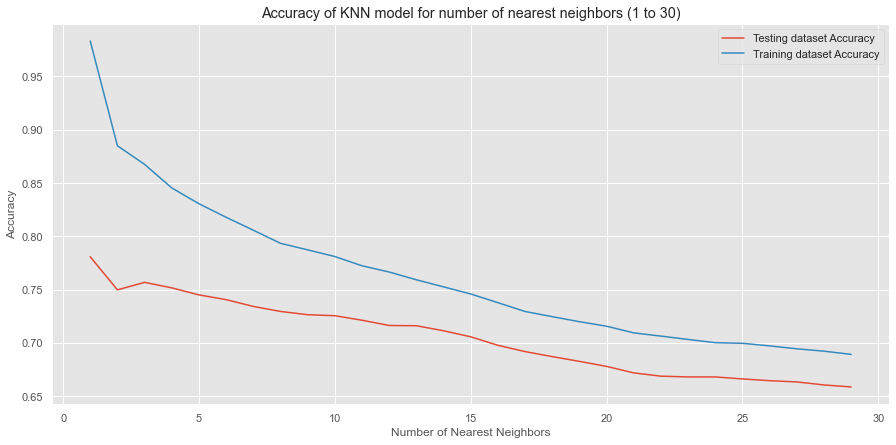

In [200]:
# plot to determine the number of nearest neighbors to use for KNN

neighbors = np.arange(1, 30)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))
 
# Loop over K values
for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(features_train_x, features_train_y)
     
    # Compute training and test data accuracy
    train_accuracy[i] = knn.score(features_train_x, features_train_y)
    test_accuracy[i] = knn.score(features_test_x, features_test_y)
 
# create plot
plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy')
 
plt.legend()
plt.xlabel('Number of Nearest Neighbors')
plt.ylabel('Accuracy')
plt.title('Accuracy of KNN model for number of nearest neighbors (1 to 30)')
plt.show()

In [213]:
# KNN model

# Set the number of nearest neighbors as 1
n_neighbors=1

knn = KNeighborsClassifier(n_neighbors)
knn01= knn
knn02 = knn

# knn for training
knn01.fit(features_train_x, features_train_y)
prediction_knn01 = knn01.predict(features_train_x)

# knn for testing
knn02.fit(features_test_x, features_test_y)
prediction_knn02 = knn02.predict(features_test_x)

In [201]:
# features for SVM model

svm_features = SA_terror_df[['attack_type', 'city_country', 'target_type', 'nearest_center_km']]

# convert categorical variables to numberic
svm_features['attack_type'] = svm_features.groupby(['attack_type']).ngroup()
svm_features['target_type'] = svm_features.groupby(['target_type']).ngroup()

# create train/test split of 03/70
svm_SA_terror_train, svm_SA_terror_test = train_test_split(svm_features, test_size =0.3)

# set train x values to be all the features excluding the target
svm_features_train_x = svm_SA_terror_train.loc[:, svm_features.columns != 'city_country']
# set train y values to be the target
svm_features_train_y = svm_SA_terror_train['city_country']

# set test x values to be all the features excluding the target
svm_features_test_x = svm_SA_terror_test.loc[:, svm_features.columns != 'city_country']
# set test y values to be the target
svm_features_test_y = svm_SA_terror_test['city_country']

<ipython-input-201-c0e9399cf91f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_features['attack_type'] = svm_features.groupby(['attack_type']).ngroup()
<ipython-input-201-c0e9399cf91f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_features['target_type'] = svm_features.groupby(['target_type']).ngroup()


In [205]:
# SVM Model
svm01 = svm.SVC()
svm02 = svm.SVC()

# SVM for training
svm01.fit(svm_features_train_x, svm_features_train_y)

# SVM for testing
svm02.fit(svm_features_test_x, svm_features_test_y)

# predicting the target for training
prediction_svm01 = svm01.predict(svm_features_train_x)

# predicting the target for testing
prediction_svm02 = svm02.predict(svm_features_test_x)

In [206]:
# cross validation

# setting the number of folds to 10
k = 10
crossvalidation = KFold(n_splits=k, shuffle=True)

# cross validation for each model
cart_cv_scores = cross_val_score(cart01, features_train_x, features_train_y, cv=crossvalidation)
c50_cv_scores = cross_val_score(c50_01, features_train_x, features_train_y, cv=crossvalidation)
rf_cv_scores = cross_val_score(rf01, features_train_x, features_train_y, cv=crossvalidation)
knn_cv_scores = cross_val_score(knn01, features_train_x, features_train_y, cv=crossvalidation)
SVM_cv_scores = cross_val_score(svm01, svm_features_train_x, svm_features_train_y, cv=crossvalidation)


In [210]:
# create a function that we can use to check how our predictions compare to the actual values
def eval_prediction(pred, actual):
    index = 0
    correct = 0
    for outcome in actual:
        if pred[index] == outcome:
            correct += 1

        index+=1
    return correct

In [215]:
print("-"*50 + " Cart Cross Validation " + "-"*50)
print("validation scores with k=10: ", cart_cv_scores)
print("Average score of all folds:",cart_cv_scores.mean())

print("-"*50 + " C50.0 Validation " + "-"*50)
print("C50.0 cross validation scores with k=10: ", c50_cv_scores)
print("Average score of all folds:",c50_cv_scores.mean())

print("-"*50 + " Random Forest Validation " + "-"*50)
print("Random Forest cross validation scores with k=10: ", rf_cv_scores)
print("Average score of all folds:",rf_cv_scores.mean())

print("-"*50 + " KNN Cross Validation " + "-"*50)
print("KNN cross validation scores with k=10: ", knn_cv_scores)
print("Average score of all folds:",knn_cv_scores.mean())

print("-"*50 + " SVM Cross Validation " + "-"*50)
print("SVM cross validation scores with k=10: ", knn_cv_scores)
print("Average score of all folds:",SVM_cv_scores.mean())

-------------------------------------------------- Cart Cross Validation --------------------------------------------------
validation scores with k=10:  [0.63004032 0.63608871 0.64112903 0.65792129 0.62462159 0.65388496
 0.63673058 0.6629667  0.63168517 0.63975782]
Average score of all folds: 0.6414826177533283
-------------------------------------------------- C50.0 Validation --------------------------------------------------
C50.0 cross validation scores with k=10:  [0.64314516 0.65423387 0.61995968 0.64682139 0.63572149 0.63168517
 0.65691221 0.6407669  0.60645812 0.67204844]
Average score of all folds: 0.6407752433189025
-------------------------------------------------- Random Forest Validation --------------------------------------------------
Random Forest cross validation scores with k=10:  [0.59778226 0.58770161 0.58266129 0.58627649 0.60040363 0.580222
 0.57517659 0.60141271 0.58224016 0.59031282]
Average score of all folds: 0.588418956088669
-------------------------------

In [216]:
# printing the accuracy rates for our test

print("-"*10 + " Acuraccy " + "-"*10)
print("Cart:", '{0:.2%}'.format(eval_prediction(prediction_cart02, features_test_y)/len(features_test_x)))
print("C5.0:", '{0:.2%}'.format(eval_prediction(prediction_c50_02, features_test_y)/len(features_test_x)))
print("Random Forest:", '{0:.2%}'.format(eval_prediction(prediction_rf02, features_test_y)/len(features_test_x)))
print("KNN:", '{0:.2%}'.format(eval_prediction(prediction_knn02, features_test_y)/len(features_test_x)))
print("SVM", '{0:.2%}'.format(eval_prediction(prediction_svm02, svm_features_test_y)/len(svm_features_test_x)))

print("-"*10 + " Precision " + "-"*9)
print("Cart:", '{0:.2%}'.format(precision_score(prediction_cart02,features_test_y,average = 'micro')))
print("C5.0:", '{0:.2%}'.format(precision_score(prediction_c50_02,features_test_y,average = 'micro')))
print("Random Forest:", '{0:.2%}'.format(precision_score(prediction_rf02,features_test_y,average = 'micro')))
print("KNN:", '{0:.2%}'.format(precision_score(prediction_knn02,features_test_y,average = 'micro')))
print("SVM:", '{0:.2%}'.format(precision_score(prediction_svm02,features_test_y,average = 'micro')))

print("-"*10 + " Recall " + "-"*12)
print("Cart:", '{0:.2%}'.format(recall_score(prediction_cart02,features_test_y,average = 'micro')))
print("C5.0:", '{0:.2%}'.format(recall_score(prediction_c50_02,features_test_y,average = 'micro')))
print("Random Forest:", '{0:.2%}'.format(recall_score(prediction_rf02,features_test_y,average = 'micro')))
print("KNN:", '{0:.2%}'.format(recall_score(prediction_knn02,features_test_y,average = 'micro')))
print("SVM:", '{0:.2%}'.format(recall_score(prediction_svm02,features_test_y,average = 'micro')))


---------- Acuraccy ----------
Cart: 65.19%
C5.0: 64.72%
Random Forest: 95.86%
KNN: 98.94%
SVM 44.86%
---------- Precision ---------
Cart: 65.19%
C5.0: 64.72%
Random Forest: 95.86%
KNN: 98.94%
SVM: 6.54%
---------- Recall ------------
Cart: 65.19%
C5.0: 64.72%
Random Forest: 95.86%
KNN: 98.94%
SVM: 6.54%


<AxesSubplot:title={'center':'Number of Terror Events In the last 50 Years'}, xlabel='Year', ylabel='Number of Attacks'>

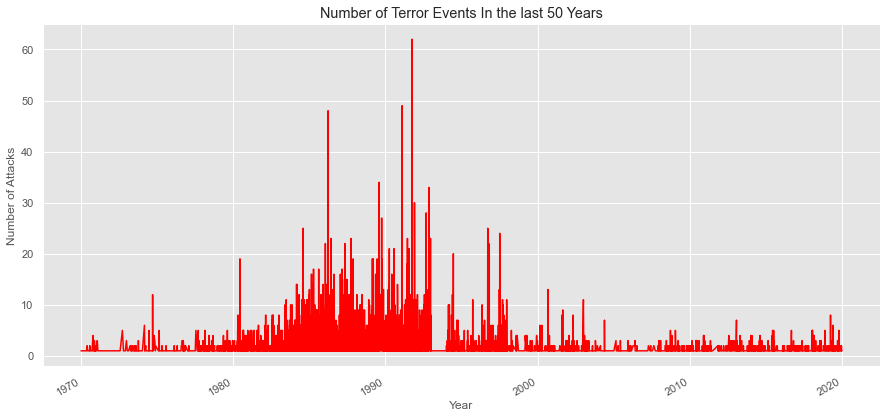

In [330]:
# plot to show terror event count per year
SA_terror_df['date'].value_counts().plot(xlabel = 'Year', ylabel = 'Number of Attacks', title='Number of Terror Events In the last 50 Years',  color='red')

<AxesSubplot:title={'center':'Number of Attacks In Each Country'}, xlabel='Country', ylabel='Number of Attacks'>

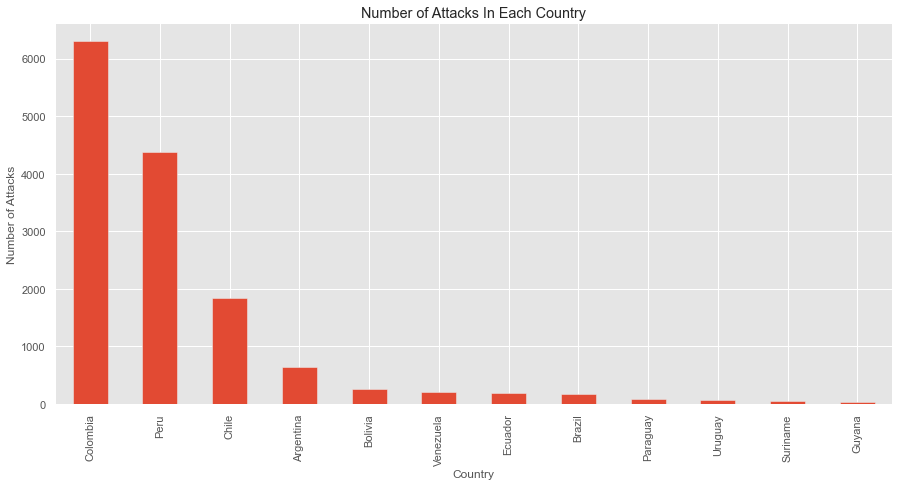

In [329]:
# plot to portray the number of terror attacks in each country
SA_terror_df.country.value_counts().plot(xlabel = 'Country', ylabel = 'Number of Attacks', title = 'Number of Attacks In Each Country', kind='bar')

<AxesSubplot:title={'center':'Top 5 Cities with the Most Terror events'}, xlabel='City', ylabel='Number of Attacks'>

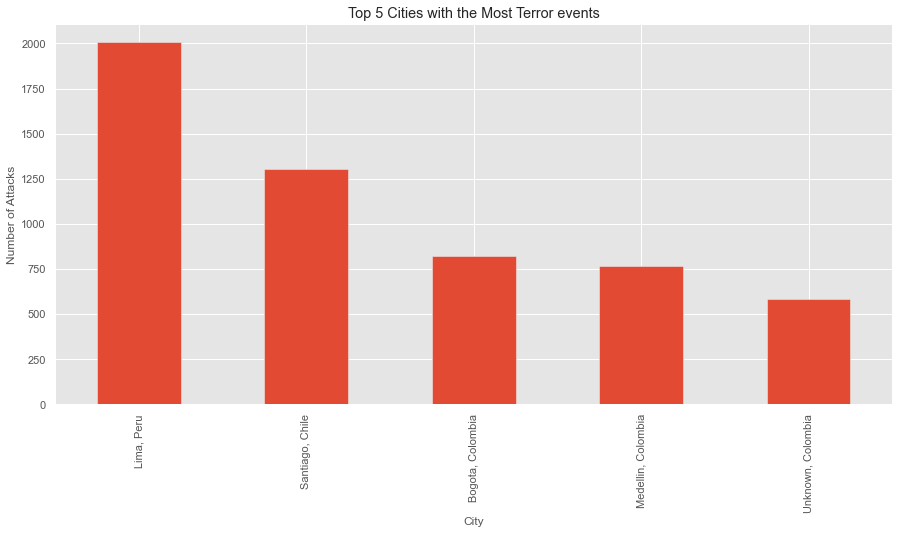

In [326]:
# plot that shows the top 5 cities based on number of attacks
SA_terror_df['city_country'].value_counts().head(5).plot(xlabel = 'City', ylabel = 'Number of Attacks', title = 'Top 5 Cities with the Most Terror events', kind='bar')

<AxesSubplot:title={'center':'Most Targeted Targets'}, xlabel='Target Type', ylabel='Number of Attacks'>

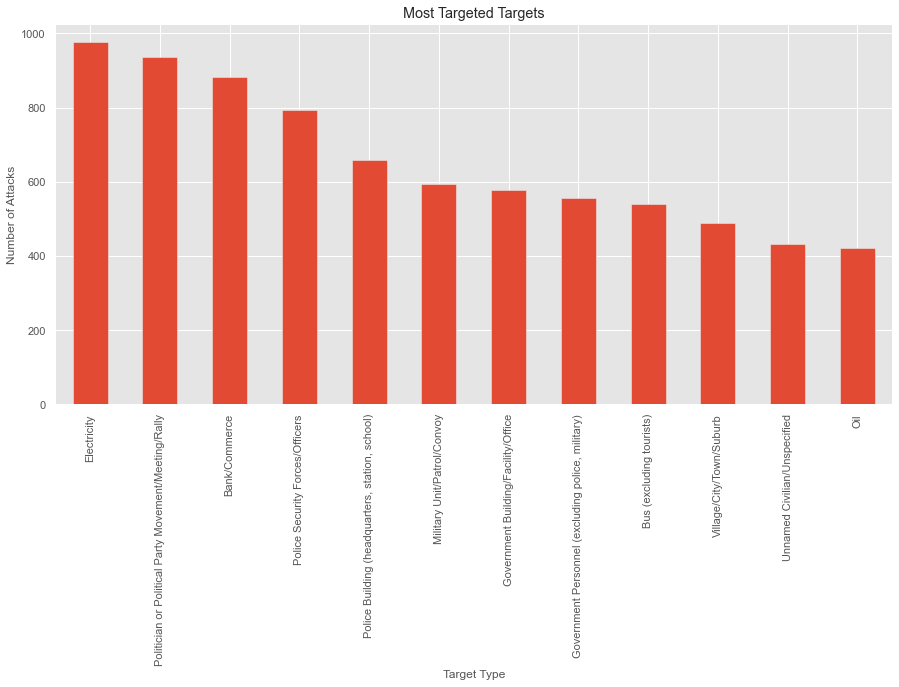

In [325]:
SA_terror_df.target_type.value_counts().head(12).plot(xlabel = 'Target Type', ylabel = 'Number of Attacks', title = 'Most Targeted Targets', kind = 'bar')

<AxesSubplot:title={'center':'Terrorist Groups With the Most Number of Kills'}, xlabel='Group Name', ylabel='Number Killed'>

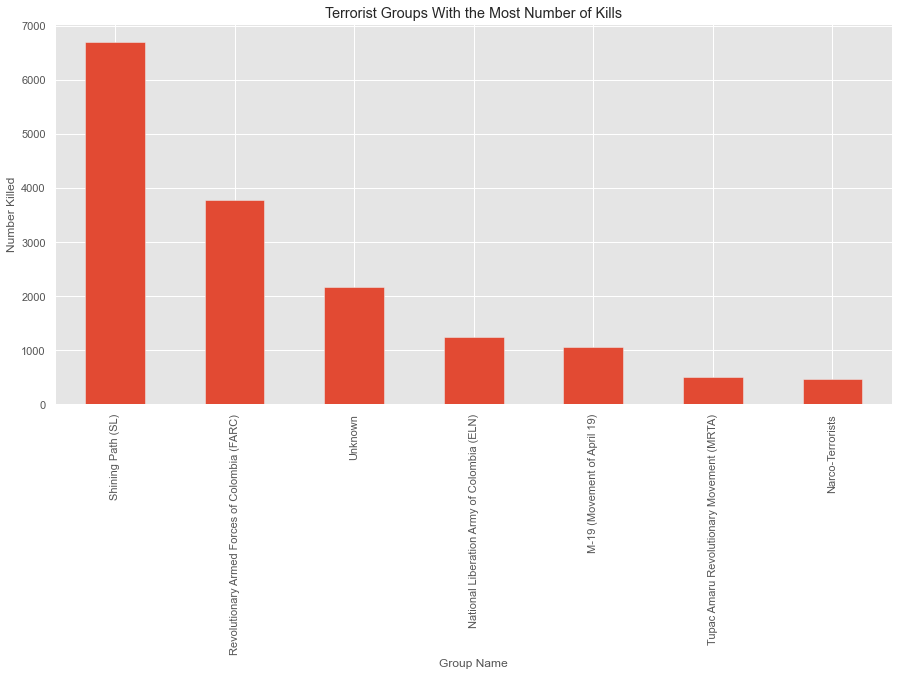

In [323]:
dangerous_group = SA_terror_df.groupby('group_name')['number_killed'].sum()
dangerous_group.sort_values(ascending = False).head(7).plot(xlabel = 'Group Name', ylabel = 'Number Killed', title = 'Terrorist Groups With the Most Number of Kills', kind = 'bar')

<AxesSubplot:title={'center':'Average Distance of Cities in Each Country to Earthquake Hotspot'}, xlabel='Country', ylabel='Distance to Earthquake hotspot'>

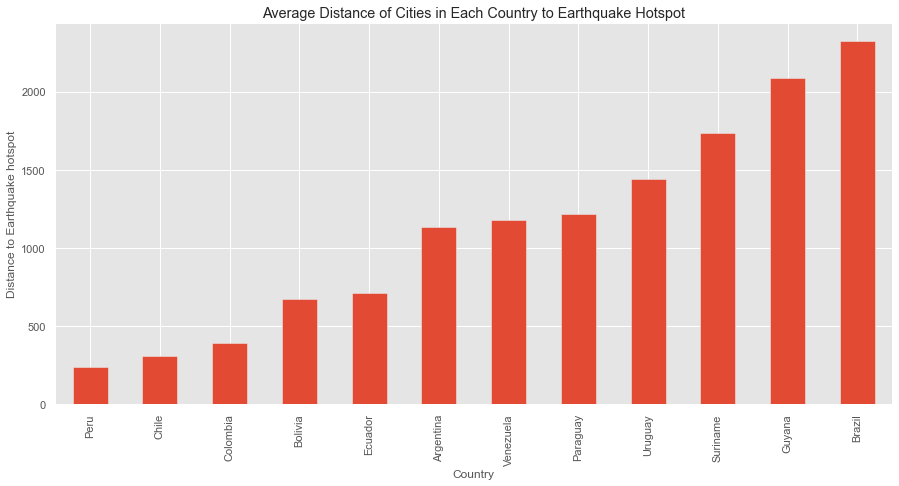

In [322]:
cities_close_to_hotspot = SA_terror_df.groupby('country')['nearest_center_km'].mean()
cities_close_to_hotspot.sort_values(ascending = True).plot(xlabel = 'Country', ylabel = 'Distance to Earthquake hotspot', title = 'Average Distance of Cities in Each Country to Earthquake Hotspot', kind = 'bar')